In [1]:
import pymc as pm
import arviz as az
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import aesara.tensor as at
import xarray as xr
import networkx as nx
import utils

plt.style.use('seaborn-talk')



# The how and why of statistically modeling student *results*


#### UvA, DSC, November 2022

<img src=https://camo.githubusercontent.com/bcfd83328eafae3e264cd9b3e51fc92bb36ba5053cab6e2ec11f6bbf044f8a28/68747470733a2f2f63646e2e7261776769742e636f6d2f70796d632d646576732f70796d632f6d61696e2f646f63732f6c6f676f732f7376672f50794d435f62616e6e65722e737667 align=right>
 

### Marcel Haas, Business Intelligence @ Executive staff UvA
m.r.haas@uva.nl

<br>
<br>

*Collaborator: Colin Caprani (Monash University)*

<br>
<br>
<br>

Get material from [Github](https://github.com/UvA-DSC/20221021_seminar_BayesianStudents): https://github.com/UvA-DSC/20221021_seminar_BayesianStudents

# Friday is my hobby project day

The Business Intelligence department, among other things, makes models that predict student performance.

<img src=img/predictions.png align=left>


We do this using "traditional" machine learning methods: focus on accurate predictions. 

### But...

# What to talk about?

<img src=https://static.thenounproject.com/png/1456735-200.png align=right width=300>


1. Bayesian Generative Modeling:

    1.1 What even is this Bayes thing?

    1.2 Simple modeling example
    
<br>

2. Student results as "continuous" Item-Response Theory problem

<br>

3. OK, now what?


# Baysian Generative *Modeling*

<img src=https://i.pinimg.com/736x/8f/c4/94/8fc4940161ba1bb786d9366dd16c022c--svg-file-fedora.jpg align=right width=600>

<br>

We are constructing a ***model*** that ***may*** have some connection to reality.

<br>

The reason for modeling is to ***learn*** about model building blocks, from ***observed data***.


# Bayesian *Generative* Modeling
<br>
<br>

<img src=https://notes.dsc80.com/_images/missing-mech.png align=center width=700>

<br>
<br>


We model the ***data generating process*** (forward modeling), assuming some ***prior knowledge***.

# *Bayesian* Generative Modeling

The knowledge about the data generating process is updated with the observed data, resulting in the current state of knowledge about the data generating process.

<img src=https://upload.wikimedia.org/wikipedia/commons/1/18/Bayes%27_Theorem_MMB_01.jpg align=center width=400>

Read this as 

$ P(\textrm{model given the data}) = P(\textrm{data given the model}) \cdot P(\textrm{model}) \cdot \textrm{Constant}$

### Or: Posterior probability distribution = Likelihood x Prior


# *Bayesian* Generative Modeling

Intermezzo: This posterior is ***really*** what you should want, when doing inference, not the likelihood.

Frequentist statistics and (often) machine learning give you a *Maximum Likelihood* estimate.

<img src=https://upload.wikimedia.org/wikipedia/commons/1/18/Bayes%27_Theorem_MMB_01.jpg align=center width=400>


# Bayesian *Generative modeling*

We model the **data generating process** (forward modeling), assuming some **prior knowledge**.

The Posterior ($P(\textrm{model given the data})$) is often complex and multi-dimensional.

$P(m|d) = \frac{P(d|m)P(m)}{C = 1}$ 

Sampling the posterior, through prior and likelihood with a Monte Carlo Markov Chain:

<img src=https://www.researchgate.net/publication/338363810/figure/fig6/AS:843249581309953@1578057775228/Illustration-of-the-Markov-chain-Monte-Carlo-with-Metropolis-Hastings-MCMC-MH-procedure.png align=center width=500>



# Example!

We have two variables that are supposed to have a linear relationship, with positive slope and some intercept.

We'll fake some data and pretend we don't know how we did it...

(After [this more elaborate notebook](https://github.com/harcel/BiteSizeDataScience/blob/main/0_LinearRegressionThreeWays/Linear_regression_3ways.ipynb))

In [2]:
# Parameters about the data:
size = 20   # number of data points
true_intercept = 4
true_slope = 6

# Create the independent variable
x = np.linspace(0, 1, size)
# Create the independent variable y = a + b*x
true_regression_line = true_intercept + true_slope * x
# add noise, drawn from a Gaussian (from numpy) with mean 0 and a standard deviation of 0.5
np.random.seed(123)
y = true_regression_line + np.random.normal(scale=.5, size=size)

# Here's what it looks like!

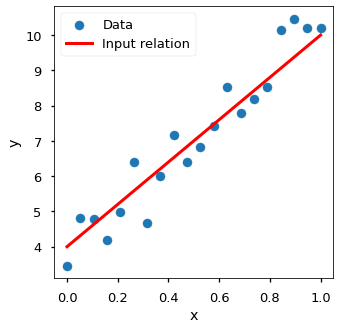

In [3]:
plt.figure(figsize=(5,5))
plt.scatter(x, y, label='Data')
plt.plot(x, true_regression_line, color='red', linewidth=3, label='Input relation')
plt.legend()
plt.xlabel('x'); plt.ylabel('y');

# Linear regression the traditional way

One could just simply do this with `statsmodels` or `scikit-learn`:

In [4]:
import statsmodels.api as sm
X = sm.add_constant(x, prepend=True)
smreg = sm.OLS(y, X)
smres = smreg.fit()
print(smres.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.929
Model:                            OLS   Adj. R-squared:                  0.925
Method:                 Least Squares   F-statistic:                     234.4
Date:                Thu, 17 Nov 2022   Prob (F-statistic):           9.16e-12
Time:                        13:30:42   Log-Likelihood:                -17.074
No. Observations:                  20   AIC:                             38.15
Df Residuals:                      18   BIC:                             40.14
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.6792      0.258     14.254      0.0

## And, using scikit-learn...

In [5]:
from sklearn.linear_model import LinearRegression
x_in = x.reshape(-1,1)
regr = LinearRegression()
regr.fit(x_in, y)
print(f'Slope {regr.coef_[0]:3.2f} and intercept {regr.intercept_:3.2f}')


Slope 6.76 and intercept 3.68


They better agree: linear regression is a deterministic process.

# Example, the Bayesian generative way

We construct a model, and then sample the posterior:

1. Assume priors (can be *uninformative*!)

    -> There's a slope, an intercept, and noise (Gaussian with positive $\sigma$)
    
    
2. Define the relation between variables (observed and latent)

In [6]:
import pymc as pm

with pm.Model() as linreg:
    # 1. Priors!
    intercept = pm.Normal('Intercept', 0, sigma=20)
    x_coeff = pm.Normal('Slope', 0, sigma=20)
    sigma = pm.HalfCauchy('sigma', beta=10)

    # 2. Relationships!
    likelihood = pm.Normal('y', mu=intercept + x_coeff * x,
                        sigma=sigma, observed=y)
    

Take special note of the `observed=` keyword in the last line!

## Models can be visualized

This is the actual computational graph used by the back-end:

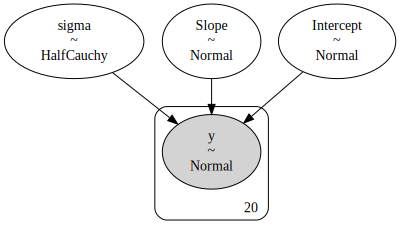

In [7]:
pm.model_graph.model_to_graphviz(linreg)

# Example, the Bayesian generative way

We construct a model, and then sample the posterior:

1. *Assume priors (can be uninformative!)*
2. *Define the relation between variables (observed and latent)*
3. Pick a sampler for the posterior
4. Sample your heart out 
5. Inspect!

In [8]:
with linreg:
    # 3. Pick a sampler, don't worry for now.
    step = pm.NUTS()
    
    # 4. Sample! Aka: The Inference button.
    trace = pm.sample(2000, cores=2, tune=2000, step=step)

Multiprocess sampling (2 chains in 2 jobs)
NUTS: [Intercept, Slope, sigma]


Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.


# Basic statistics of the posterior(s)

In [9]:
pm.summary(trace) # A summary of the results for all stochastic variables

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,3.697,0.293,3.145,4.262,0.008,0.006,1300.0,1521.0,1.0
Slope,6.728,0.505,5.711,7.631,0.014,0.010,1311.0,1383.0,1.0
sigma,0.644,0.119,0.447,0.865,0.003,0.002,1709.0,1348.0,1.0


# Let's have a look

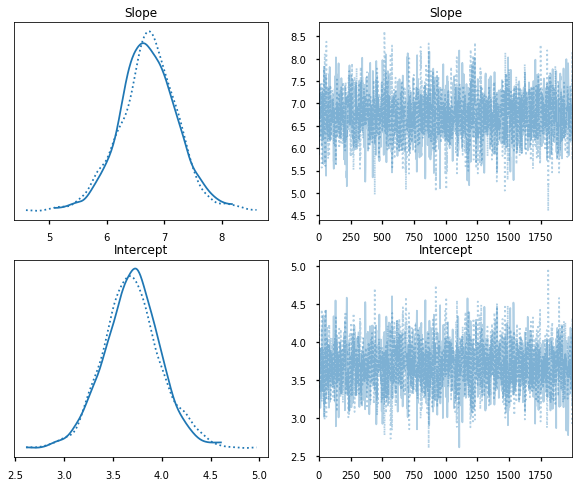

In [10]:
# Plotting functionality for traces is provided by the package Arviz
az.plot_trace(trace, var_names=['Slope', 'Intercept'], figsize=(10,8));

# Free goodies: the joint posterior

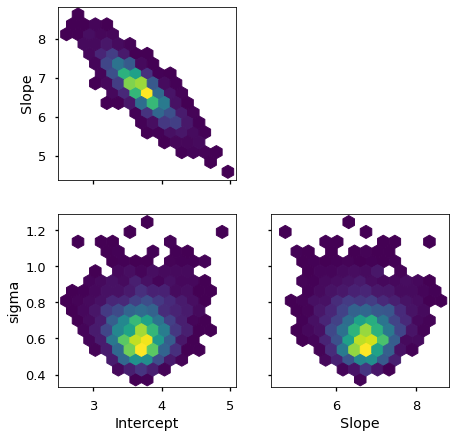

In [11]:
az.plot_pair(trace, kind='hexbin', figsize=(7,7));

Note the areas of ~zero posterior probability! Try to find *that* with statsmodels or scikit-learn!

## What do these models look like?

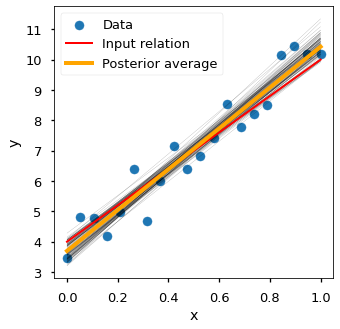

In [12]:
utils.plot_sampled_models(trace, x=x, y=y)

## Flexibility really pays off with more complicated models

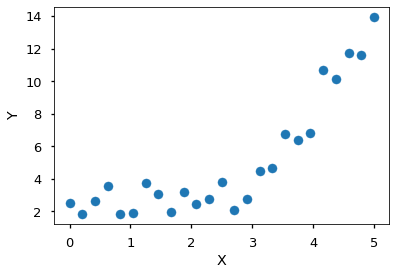

In [2]:
npoints = 25
np.random.seed(42)
x_data = np.linspace(0,5, npoints)
y_data = np.clip(x_data**3/10 + 2 + np.random.normal(size=npoints), 0, None)
plt.scatter(x_data, y_data)
plt.xlabel('X')
plt.ylabel('Y');

#### Let's model this with a constant and a linear function, meeting at a switchpint

In [3]:
with pm.Model() as flat_lin:
    # Priors
    x_coeff = pm.HalfNormal('Slope', sigma=30)
    const = pm.Normal('Constant', sigma=5)
    switchpoint = pm.Uniform('Switchpoint', lower=np.percentile(x_data, 25), upper=np.percentile(x_data, 75))
        
    sigma = pm.HalfNormal('sigma', sigma=10)
    
    # Relationships
    lin_part = x_data * x_coeff - switchpoint*x_coeff + const
    y_ref = pm.math.switch(at.gt(switchpoint, x_data), const, lin_part)
    
    likelihood = pm.Normal('Y', mu=y_ref, sigma=sigma, observed=y_data)
    
    trace_ex = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Slope, Constant, Switchpoint, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.
The acceptance probability does not match the target. It is 0.8831, but should be close to 0.8. Try to increase the number of tuning steps.


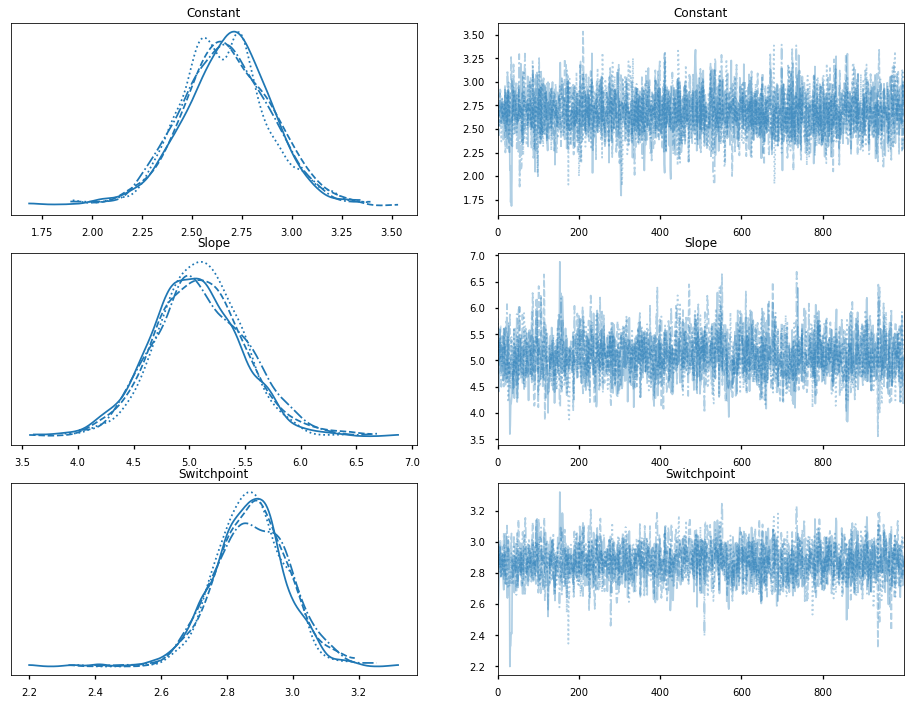

In [4]:
az.plot_trace(trace_ex, var_names=['Constant', 'Slope', 'Switchpoint'], figsize=(16,12));

In [5]:
pm.summary(trace_ex)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Constant,2.671,0.226,2.264,3.114,0.004,0.003,2753.0,2364.0,1.0
Slope,5.085,0.401,4.325,5.825,0.011,0.008,1280.0,1802.0,1.0
Switchpoint,2.873,0.111,2.663,3.067,0.003,0.002,1433.0,1853.0,1.0
sigma,0.825,0.133,0.593,1.078,0.003,0.002,1646.0,1046.0,1.0


## And the resulting models look just fine!

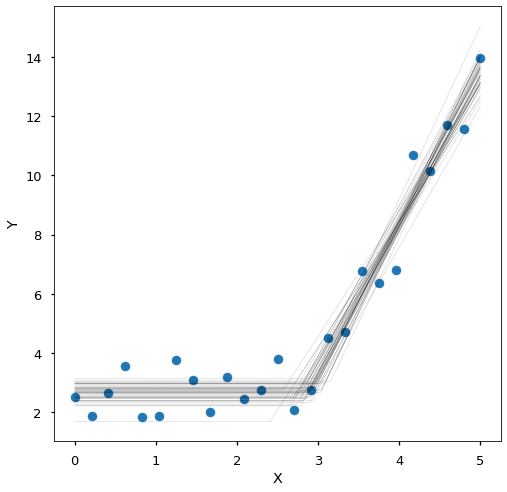

In [6]:
utils.plot_switch_example(trace_ex, 50, x=x_data, y=y_data)

<img src=img/DenseNetwork.png align=right width=500> 

# Application!
## Modeling student results in networks


1. Students get grades that are a result of their ability and the test/course difficulty
2. Students take courses, including electives, in variously composed groups

<br>
<br>
<br>

Therefore, in principle, we can derive difficulty and ability for many students over many courses simultaneously.

## Grades

- When your ability is high, you're more likely to get a high grade

- When a course is easy, you're more likely to get a high grade

#### Assumption:

$$
g = 4 \cdot \frac{1}{1+\exp(-(\alpha -\delta))} + 6
$$

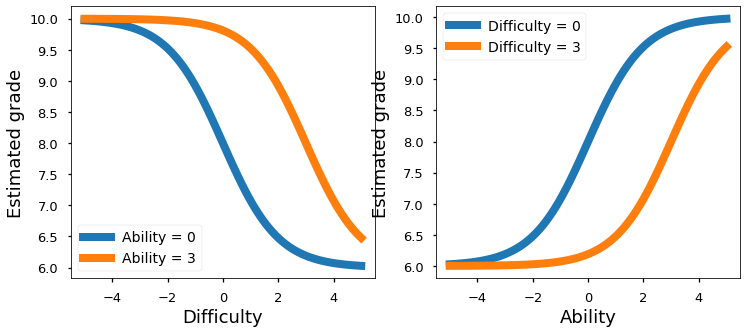

In [35]:
utils.plot_example_grades()

Item Response Theory is a Pass/Fail-binary version of this, often used for questions within one test.

# Networks!

Students do courses. Some courses are taken by the same students. 

In the network, **nodes are courses, edges are overlapping student groups**.

<br>
<br>

<img src=img/IncompleteNetwork.png align=center width=500> 


### We *need* the network to be connected!

<img src=img/CompleteNetwork.png align=center width=500>

Note that not *everybody* needs to do the connecting course!

### Let's create an imaginary data set that describes this network


<img src=img/CompleteNetwork.png align=right width=300>
All students do "course X".

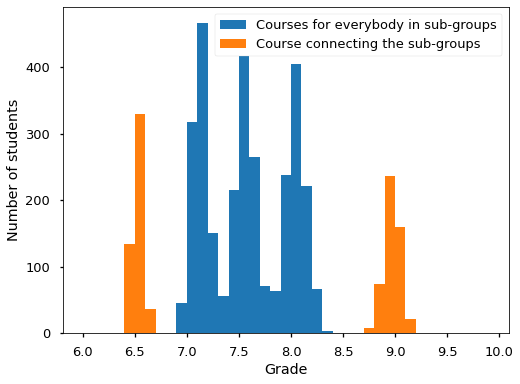

In [2]:
n_st = 500                             # Number of students
grades = utils.create_data(n_st=n_st)  # Fake data, low noise on grades

plt.figure(figsize=(8,6))
plt.hist(grades.flatten(), bins=np.arange(6,10,.1), label="Courses for everybody in sub-groups")
plt.hist(grades[:,3], bins=np.arange(6,10,.1), label="Course connecting the sub-groups")
plt.xlabel('Grade'); plt.ylabel("Number of students"); plt.legend();

#### Whats the data like?

In [3]:
grades_df = utils.grade_df(grades)
grades_df.head()

,StudentNumber,Course,Grade
0,0,Course A,8.2
1,1,Course A,8.0
2,2,Course A,8.1
3,3,Course A,8.2
4,4,Course A,8.2


In [4]:
pd.DataFrame(grades_df.groupby('Course').Grade.mean())

,Grade
Course,
Course A,8.0026
Course B,7.5144
Course C,7.0796
Course D,7.9950
Course E,7.5098
Course F,7.0774
Course X,7.7019


#### A re-usable function knows how to model

The *course difficulties* ($\delta$) are unkown, just like *student abilities* ($\alpha$)

$$
\delta, \alpha \sim \textrm{Normal}(0,3)
$$

The resulting grade is the expected grade, with some unknown scatter

$$
\begin{eqnarray}
ge & = & 4 \cdot \frac{1}{1+\exp(-(\alpha -\delta))} +6 \\
g  & \sim &  \textrm{Normal}(ge, \epsilon) \\
\epsilon & \sim & \textrm{HalfNormal}(1)
\end{eqnarray}
$$

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Course difficulty, Student ability, eps]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 22 seconds.


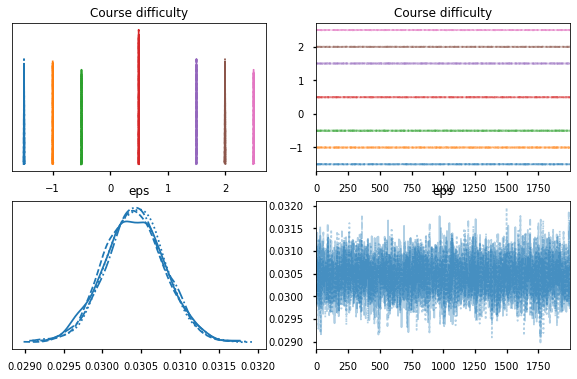

In [5]:
tr, simulatie = utils.model_and_visualize(grades_df)

# The model looks like this

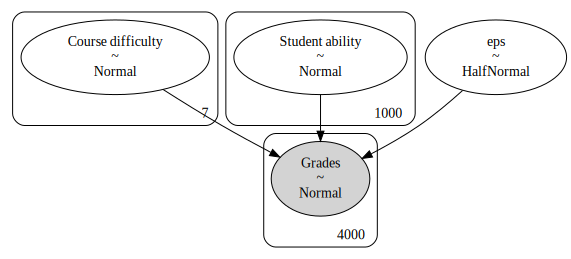

In [6]:
pm.model_graph.model_to_graphviz(simulatie)

# Conclusion from some simple experiments

1. We can put large noise on the grades ...
2. We can make the abilities and difficulties spread out much more ...
3. We can decrease the number of people who follow Course X to 10% ...

And *still* the abilities and difficulties are recovered very well!


<br>
<br>
<br>
(note: we happen to assume a relation between grade, ability, and difficulty that is exactly correct)

# Real data!

<img src=https://pbs.twimg.com/profile_images/1199221965321654272/0zioqYei_400x400.jpg align=right width=200>

<br>

Exam results from Law School students, passes only, from a few years ago.

<br>
<br>
<br>

1. Identify networks
2. Model student ability and course difficulty in fully connected networks

In [2]:
scores = utils.read_student_data()
print(f'There are {scores.shape[0]} student results here!')
scores.head()

There are 51752 student results here!


,StudentNumber,Grade,Program,Course
0,3690623392064879625,7.0,50700,3012FSX8V
1,7109174390294159737,7.5,60223,3454IPQ5V
2,884370123749021926,8.7,59312,3801DMQPV
3,9158614493762529642,10.0,50700,3011CRX7V
4,6777876230243551339,8.7,50700,3011ISX8V


### Complicated networks in real life....

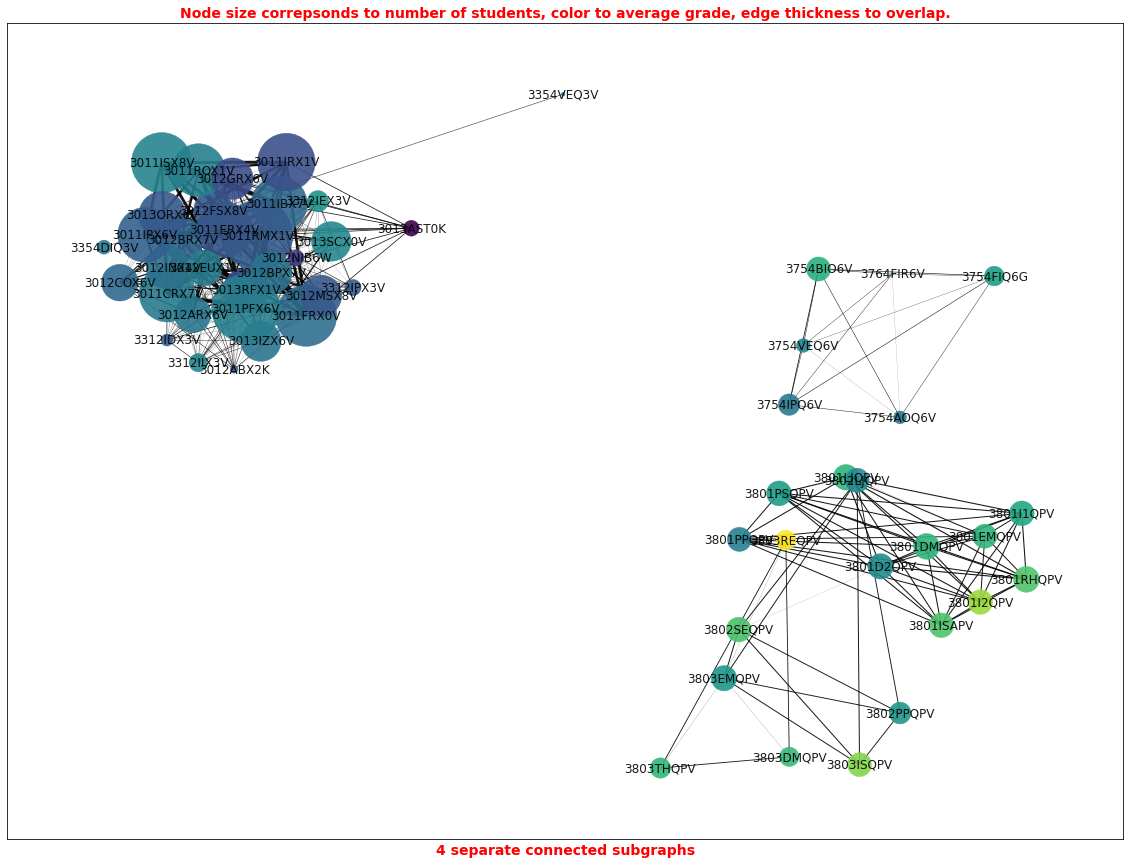

In [3]:
from utils import course_network, show_course_network
course_net = course_network(scores)
show_course_network(course_net, kind='spring')

### Let's select the largest connected subgraph!

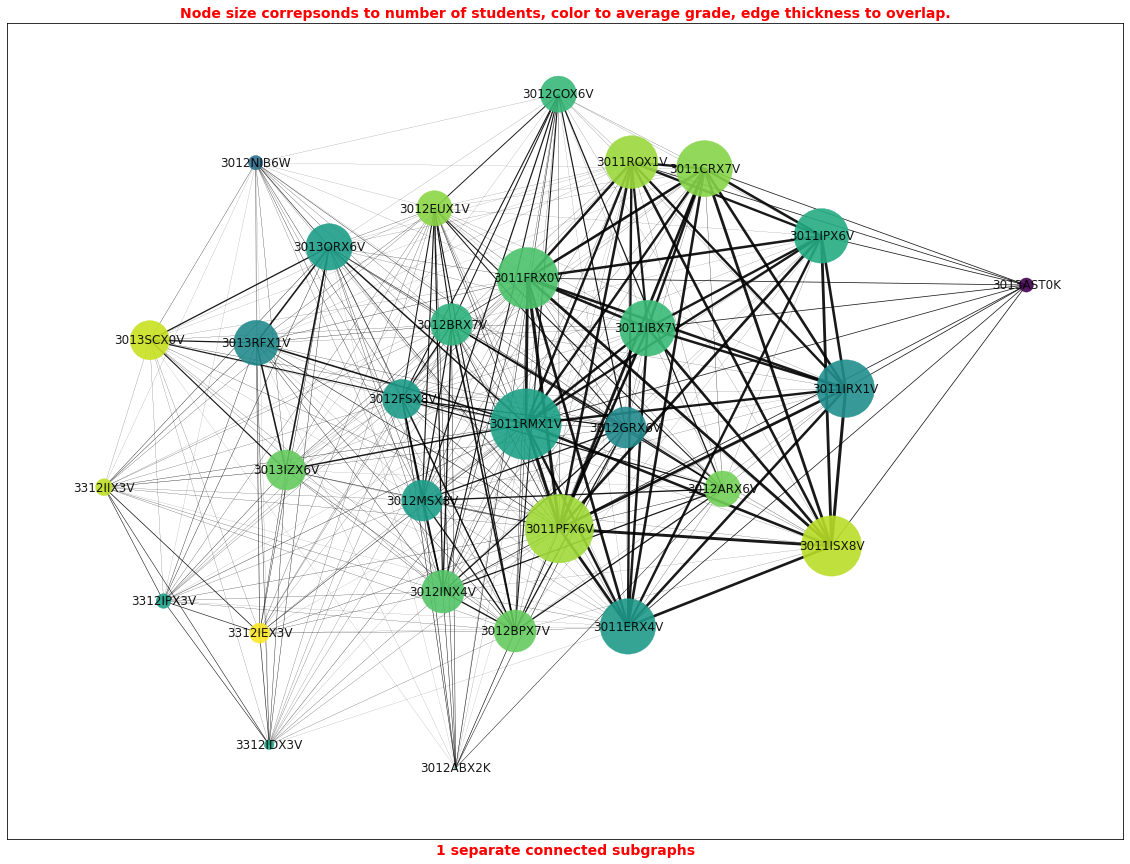

In [4]:
largest = course_net.subgraph(max(nx.connected_components(course_net), key=len))
show_course_network(largest, kind='spring')

#### Selecting the results from that largest sub-network

In [21]:
results_network = scores[((scores.Course.isin(list(largest.nodes))) & 
                          (scores.Grade >= 6))]#[['StudentNumber', 'Course', 'Grade']]
print(f'There are {len(np.unique(results_network.StudentNumber))} students')
pd.DataFrame(results_network.groupby('Course').StudentNumber.nunique()).describe().loc[['count', 'mean', 'min', 'max'],:]

There are 1985 students


,StudentNumber
count,30.000000
mean,398.333333
min,108.000000
max,858.000000


Note that for these results, the assumption about grade(ability, difficulty) is not neceassrily true... 

#### Let's model!

Multiprocess sampling (2 chains in 2 jobs)
NUTS: [Course difficulty, eps, Student ability]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 169 seconds.


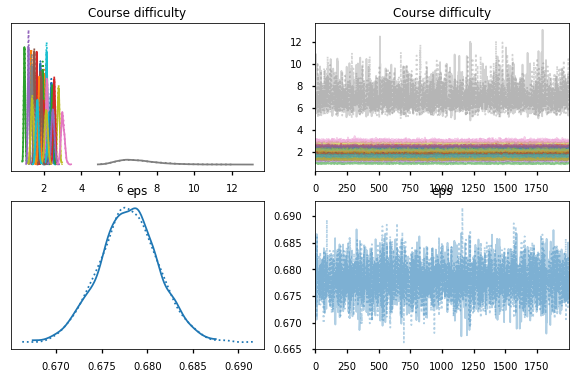

In [24]:
trace_grades = model_and_visualize(results_network)

Multiprocess sampling (2 chains in 2 jobs)
NUTS: [Course difficulty, eps, Student ability]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 172 seconds.


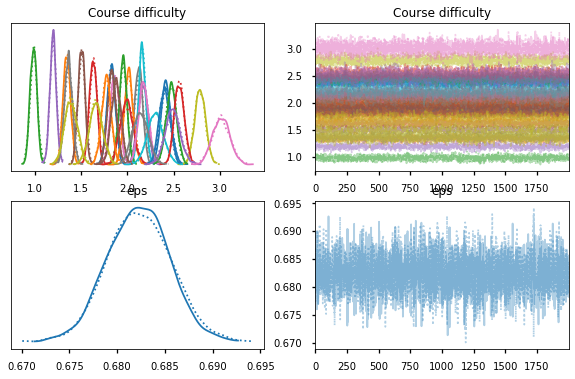

In [25]:
results_network = results_network[results_network.Course != "3013AST0K"]
trace_grades = model_and_visualize(results_network)

Looking pretty good!

## And what would we, practically, use that for?

<img src=https://parade.com/.image/t_share/MTkwNTgwOTUyNjU2Mzg5MjQ1/albert-einstein-quotes-jpg.jpg align=right width=200>

<br>



- Identify the most brilliant student at the UvA
- Identify the easiest diplomas to score


## Seriously though...

1. Catch cheaters

<br>

<img src=img/Caprani_model.png align=left width=1200>

<br>
<br>
<br>

(work by Colin Caprani at Monash University)

## Seriously though...

1. Catch cheaters


2. Identify courses that don't fit well within a program
3. Input to a minor/elective recommender system
4. Informed input for models like we have in use!

## Work to do

<img src=https://www.insperity.com/wp-content/uploads/2017/02/Hiring-for-diversity-vs-skill-sets-How-do-you-find-a-balance-640x302.png align=right width=500>


My favorite next step (after weeks of cleaning data...):

<br>
<br>
<center>
    Do we need <b><i>a set of "skills" </i></b> to describe the whole UvA populations?
    
</center>

<br>
<br>

If so: how many? 
    
And: do they correlate with faculty? Or examination type? Or ...?

## So, in your humble opinion...


1. What is interetsing for the UvA, professors, study advisors, directors of education...?
2. What is interesting to you?
3. Besides all this student progress business
    - Bayesian generative modeling is powerful, flexible and awesome, right?
    - Can/will/do you use it? Why not?

<img src=https://t3.ftcdn.net/jpg/02/91/52/22/360_F_291522205_XkrmS421FjSGTMRdTrqFZPxDY19VxpmL.jpg align=right width=500>

